This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

## Interpreting what convnets learn

### Visualizing intermediate activations

In [1]:
# You can use this to load the file "convnet_from_scratch_with_augmentation.keras"
# you obtained in the last chapter.
from google.colab import files
files.upload()

In [3]:
from tensorflow import keras
model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
model.summary()

**Preprocessing a single image**

In [8]:
from tensorflow import keras
import numpy as np

img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

2025-04-10 21:52:47.630958: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


80329/80329 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step


**Displaying the test picture**

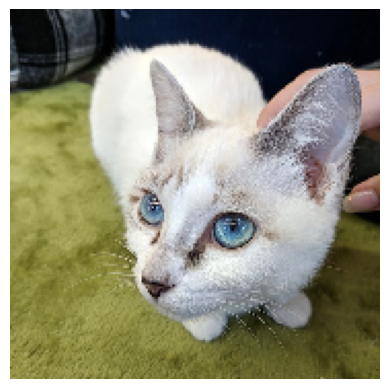

In [10]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

**Instantiating a model that returns layer activations**

In [12]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

**Using the model to compute layer activations**

In [18]:
activations = activation_model.predict(img_tensor)

In [16]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

**Visualizing the fifth channel**

In [20]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")

**Visualizing every channel in every intermediate activation**

In [23]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

### Visualizing convnet filters

**Instantiating the Xception convolutional base**

In [1]:
model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False)

**Printing the names of all convolutional layers in Xception**

In [4]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

**Creating a feature extractor model**

In [6]:
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

**Using the feature extractor**

In [8]:
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

In [10]:
import tensorflow as tf

def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

**Loss maximization via stochastic gradient ascent**

In [12]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

**Function to generate filter visualizations**

In [14]:
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

**Utility function to convert a tensor into a valid image**

In [16]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

In [20]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))

**Generating a grid of all filter response patterns in a layer**

In [22]:
all_images = []
for filter_index in range(64):
    print(f"Processing filter {filter_index}")
    image = deprocess_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

keras.utils.save_img(
    f"filters_for_layer_{layer_name}.png", stitched_filters)

### Visualizing heatmaps of class activation

**Loading the Xception network with pretrained weights**

In [ ]:
model = keras.applications.xception.Xception(weights="imagenet")

**Preprocessing an input image for Xception**

In [ ]:
img_path = keras.utils.get_file(
    fname="elephant.jpg",
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

In [ ]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

In [ ]:
np.argmax(preds[0])

**Setting up a model that returns the last convolutional output**

In [ ]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

**Reapplying the classifier on top of the last convolutional output**

In [ ]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

**Retrieving the gradients of the top predicted class**

In [ ]:
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

**Gradient pooling and channel-importance weighting**

In [ ]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

**Heatmap post-processing**

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

**Superimposing the heatmap on the original picture**

In [ ]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

## Summary